# **Wikiwomen: An analysis on gender bias**
*metADAta*

We begin with taking a look at the Wikispeedia dataset and importing the files from it. The dataframe `female` is an additional dataset that we constructed ourselves.

### **Dataframes: Columns and descriptions**

| Name of dataframe | Columns                                                         | Description                                                                   |   |   |
|-------------------|-----------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| articles          | [article]                                                       | Contains the name of a wikispeedia article                                    |   |   |
| categories        | [article, category]                                             | Contains the name of a wikispeedia article and its corresponding category     |   |   |
| links             | [link_source, link_target]                                      | Contains the source and target article between links         |   |   |
| paths_finished    | [hashedIpAddress, timestamp, durationInSec, path, rating]       | Contains all finished paths                                                   |   |   |
| paths_unfinished  | [hashedIpAddress, timestamp, durationInSec, path, target, type] | Contains all unfinished paths. Type refers to the reason they were unfinished |   |   |
| shortest_distance_text  | array | Every row corresponds to a source article, in the same order as they appear in *articles*, and its value contains the shortest distance from that source article to every other article.  |   |   |
| female  | [name, womenLabel] | Contains a list of articles about females and their corresponding subcategory |   |   |

### **Importing the data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"

In [2]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

### **Data preproccessing and visualizations**

For our project, we are mainly interested in one category within the Wikispeedia dataset, namely the category of People, the one colored red in the following bar plot. 

In [3]:
main_categories = pd.concat([categories, categories['category'].str.split(".", expand=True)], axis=1)
main_categories = main_categories.drop(columns = ["category", 0, 2, 3])
main_categories = main_categories.rename(columns = {"article": "name", 1: "main_category"})

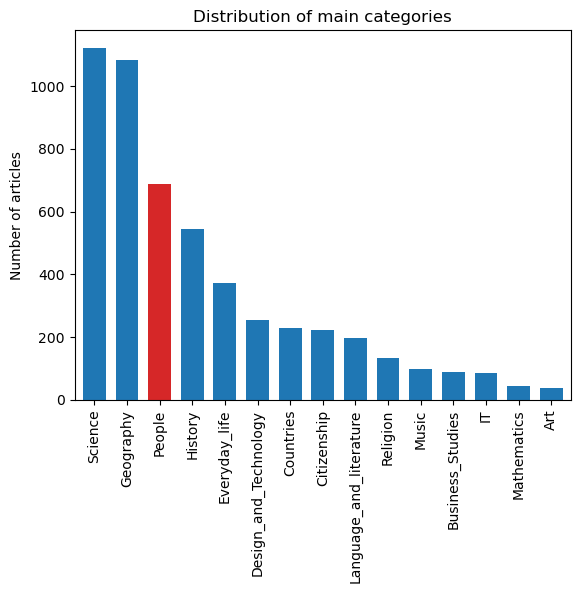

In [4]:
# plotting the distribution of main_categories
maincategories_dist = main_categories["main_category"].value_counts()
colors = ['tab:red' if (x == "People") else 'tab:blue' for x in maincategories_dist.keys()]
maincategories_dist.plot.bar(title = "Distribution of main categories",
                             ylabel = 'Number of articles', 
                             color = colors,
                             width = 0.7)
plt.show()

We will now take a closer look of the articles and their subcategories within the People category.

In [5]:
# finding the articles that are in the People category
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))

# constructing a new dataframe called people, only with articles from the people category
people = categories[categories["category_people"] == True]

# splitting the categories into main- and subcategories
people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns = ["category_people", "category", 0, 1])
people = people.rename(columns = {"article":"name", 2:"category"})

The number of articles about people are 689


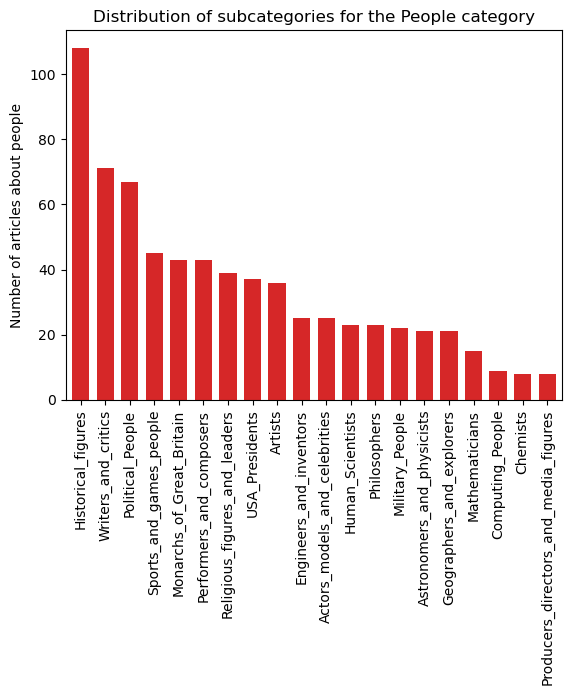

In [6]:
print(f"The number of articles about people are {len(people)}")

# plotting the distribution of subcategories within the People category
subcategories_dist = people["category"].value_counts()
subcategories_dist.plot.bar(title = "Distribution of subcategories for the People category",
                            ylabel = 'Number of articles about people', 
                            color = "tab:red", width = 0.7)
plt.show()

For our project goals, we need to be able to identify between women and men articles. In the following cells, we will do so by using the `female` dataframe, as well as finding every node degree, i.e., every number of incoming and outcoming links from every article.

In [7]:
# identify women and men in people
people["gender"] =  people['name'].isin(female["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")

# counting in- and out-links for every article
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()

# drop all people that have no in_link -> impossible to reach the article
people = people.merge(count_links_src, how = "left", left_on = "name", right_index = True)
people = people.merge(count_links_target, how = "inner", left_on = "name", right_index = True)
people = people.rename(columns = {"link_source": "nr_link_out", "link_target": "nr_link_in"})
people.head()

,name,category,gender,nr_link_out,nr_link_in
95,Abel_Tasman,Geographers_and_explorers,male,14,5
105,Abraham_Lincoln,USA_Presidents,male,35,62
129,Adam_Smith,Historical_figures,male,27,38
134,Adolf_Hitler,Political_People,male,78,109
159,Agamemnon,Historical_figures,male,11,9


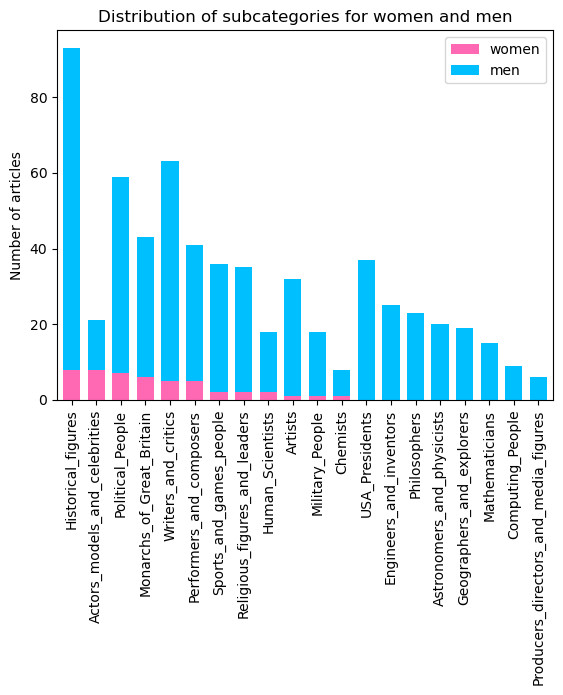

In [8]:
women_people = people[people['gender'] == "female"]["category"].value_counts()
men_people = people[people['gender'] == "male"]["category"].value_counts()
index = men_people.keys()
men_women_cat = pd.DataFrame({'women': women_people,'men': men_people}, index=index).sort_values(by = ["women"], ascending = False)
ax = men_women_cat.plot.bar(stacked = True, color = ['hotpink', 'deepskyblue'], 
                            title = "Distribution of subcategories for women and men",
                            ylabel = 'Number of articles', width = 0.7)

plt.show()

Now, we will construct a new dataframe called `path_overview` that contains the following columns:

| **Column_name**      | **Description**                                                     |
|----------------------|---------------------------------------------------------------------|
| source               | Source article of navigated path                                    |
| target               | Target article of navigated path                                    |
| finished             | True if path was finished, false otherwise                          |
| human_path_length    | The length of the path it took the user to go from source to target |
| shortest_path_length | Shortest possible path from a source to a target                    |
| durationInSec        | Duration of game                                                    |
| type                 | Reason for unfinished game                                          |
| failure_article      | Title of article where game was failed (unfinished)                 |
| rating               | Difficulty rating done by players                                   |
| hashedIpAddress      | hashedIpAddress of played game                                      |
| timestamp            | timestamp of played game                                            |

In [9]:
def process_path(path):
    '''
    Decompose a path and find its length. 
    Assumption: When back-clicks are encountered, we increase the path length by 1.
    :param path: a full-length path
    :return: source, target, length
    '''
    p = path.split(";")
    backclick = p.count('<')
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length, backclick

In [10]:
# expand the finished paths 
path_fin = paths_finished.copy()
path_fin["source"], path_fin["target"],path_fin["human_path_length"], path_fin["backclicks"] = zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_fin["finished"] = True

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin["source"], path_ufin["failure_article"], path_ufin["human_path_length"], path_ufin["backclicks"]= zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_ufin["finished"] = False
path_ufin['target'] = paths_unfinished["target"]

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)  
path_overview = path_overview[["source", "target", "finished", "human_path_length", 
                               "durationInSec", "type", "failure_article", "rating","backclicks",
                               "hashedIpAddress", "timestamp"]]

**Finding the shortest path length and adding it to `path_overview`:**

We begin with creating a matrix with the shortest path length information from the imported file *shortest-path-distance-matrix.txt*:

In [11]:
# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] 
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): 
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)

We make sure that paths with target articles that don't exist are deleted:

In [12]:
condition = ~(path_overview['target'].isin(articles['article'].array))
path_overview = path_overview.drop(path_overview[condition].index)

Now we define a function that accesses the corresponding short distance value of a source and target pair in the matrix `shortest_distance_matrix`:

In [13]:
def get_shortest_distance(source, target, help_articles):
    '''
    Finding the shortest path length between a source and a target
    :param source: source article 
    :param target: target article
    :param help_articles: a helper dataframe where article and index are changed
    :return: shortest_distance_matrix value for source and target article
    '''
    source_idx = help_articles.loc[source]
    target_idx = help_articles.loc[target]
    return shortest_distance_matrix[source_idx,target_idx][0]

Calling the function, we can add the shortest path length to `path_overview`:

In [14]:
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
path_overview["shortest_path_length"] = path_overview.apply(lambda x: get_shortest_distance(x["source"], x["target"], 
                                                                                            help_articles), axis = 1)

Below, we remove all infeasible paths, i.e., all source and target pairs that have a shortest path length value of -1:

In [15]:
path_overview = path_overview.drop(path_overview[path_overview['shortest_path_length'] < 0].index) 
path_overview.insert(4, 'shortest_path_length', path_overview.pop('shortest_path_length'))
path_overview

,source,target,finished,human_path_length,shortest_path_length,durationInSec,type,failure_article,rating,backclicks,hashedIpAddress,timestamp
0,14th_century,African_slave_trade,True,9,3,166,NaN,NaN,NaN,0,6a3701d319fc3754,1297740409
1,14th_century,African_slave_trade,True,5,3,88,NaN,NaN,3.0,0,3824310e536af032,1344753412
2,14th_century,African_slave_trade,True,8,3,138,NaN,NaN,NaN,0,415612e93584d30e,1349298640
3,14th_century,Greece,True,4,2,37,NaN,NaN,NaN,0,64dd5cd342e3780c,1265613925
4,14th_century,John_F._Kennedy,True,7,3,175,NaN,NaN,3.0,0,015245d773376aab,1366730828
...,...,...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,False,8,3,180,restart,Ghana,NaN,1,109ed71f571d86e9,1389787605
76189,Modern_history,Hollandic,False,1,3,6,restart,Modern_history,NaN,0,232f992e57d43e8d,1389787697
76190,Computer_programming,The_Beatles,False,5,3,1900,timeout,<,NaN,1,2e09a7224600a7cd,1389798400
76191,Jamaica,Alan_Turing,False,4,3,1903,timeout,Battle_of_Midway,NaN,0,60af9e2138051b96,1389799481


In [16]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")

Let's turn our attention to all people, and identify the paths in `path_overview` that only have people as target article:

In [17]:
# find only targets that are people
people_target_paths = path_overview.merge(people[['name', 'category', 'gender']], 
                                          how = "inner", left_on = "target", right_on = "name")

We can then find all paths that have women-targets and all paths that have men-targets:

In [18]:
# find only targets that are women
women_target_paths = people_target_paths[people_target_paths['gender'] == "female"]
print(f"The number of paths that have women as a target article is {len(women_target_paths)}")

The number of paths that have women as a target article is 689


In [19]:
# find only targets that are men
men_target_paths = people_target_paths[people_target_paths['gender'] == "male"]
print(f"The number of paths that have men as a target article is {len(men_target_paths)}")

The number of paths that have men as a target article is 8140


**A closer look of men vs. women articles**

In [20]:
women = len(people_target_paths[people_target_paths['gender'] == "female"])
men = len(people_target_paths[people_target_paths['gender'] == "male"])
women_finished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == True)])
men_finished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == True)])
women_unfinished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == False)])
men_unfinished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == False)])

print(f"Number of paths with a woman as a target {women} ({(women/(women+men))*100:.2f} % (of paths with a target related to a person))")
print(f"Number of paths with a man as a target {men} ({(men/(women+men))*100:.2f} %)")
print()
print(f"Number of finished paths with a woman as a target {women_finished} ({(women_finished/(women_finished+men_finished))*100:.2f}%)")
print(f"Number of finished paths with a man as a target {men_finished} ({(men_finished/(women_finished+men_finished))*100:.2f}%)")
print()
print(f"Number of unfinished paths with a woman as a target {women_unfinished} ({(women_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")
print(f"Number of unfinished paths with a man as a target {men_unfinished} ({(men_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")

Number of paths with a woman as a target 689 (7.80 % (of paths with a target related to a person))
Number of paths with a man as a target 8140 (92.20 %)

Number of finished paths with a woman as a target 347 (5.71%)
Number of finished paths with a man as a target 5727 (94.29%)

Number of unfinished paths with a woman as a target 342 (12.41%)
Number of unfinished paths with a man as a target 2413 (87.59%)


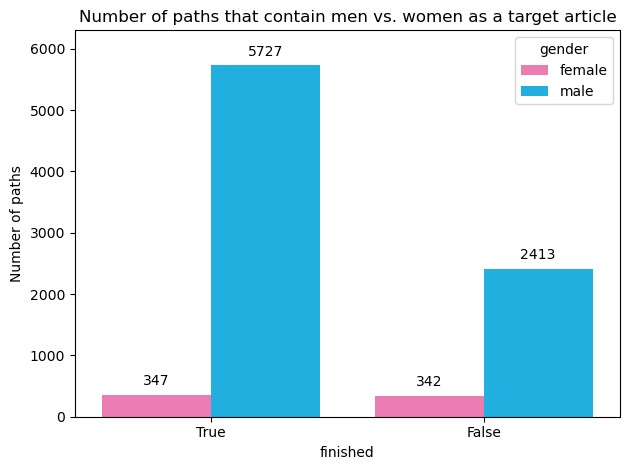

In [21]:
ax = sns.countplot( data=people_target_paths, x = "finished", hue="gender", 
                    order = [True,False], hue_order=["female","male"], palette = ['hotpink','deepskyblue'])
 
ax.set_title('Number of paths that contain men vs. women as a target article')
ax.set_ylabel("Number of paths")
ax.margins(y=0.1) # make room for the labels
for bars in ax.containers:
    ax.bar_label(bars, padding = 5)
plt.tight_layout()
plt.show()

To compute the success rate of finishing a path with a certain target article, we will count how many times a game with a certain target article was finished, and divide it with the total number of paths where it was the target:

In [22]:
# count total, finished and unfinished number of times a target article was reached
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")

# add this information to the people dataframe
people = people.merge(tot_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(unf_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(fin_target, how = "left",  left_on = "name", right_index = True)

In [23]:
# compute success rate of finishing a path
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']

In [24]:
people.to_csv("./data/people_overview.csv")

### **Controlling for all confounding factors** 

Now, we will create pairs of paths that we will compare. The target articles of the pairs are a women article and a man article. Both paths in every pair are either finished or unfinished, in other words, we do not pair a finished path with an unfinished one. 

Example: If five different paths exist from the source article *14th_century* towards the target article *Elizabeth_I_of_England*, and two different paths exist from the same source article towards the target article *John_F._Kennedy*, we would get $5 \times 2 = 10$ number of pairs to compare.

We note that it is possible that some people appear in more than one subcategory, and this would mean that pairs of paths are duplicated. We assume that the combination of `hashedIpAddres` and `timestamp` is unique for every path, so  using that we remove the duplicated pairs.

In [25]:
w = women_target_paths.groupby(women_target_paths['name']).nunique()
print('{} of the {} women used as target articles appear in more than one subcategory'.format(len(w[w['category'] > 1]) ,len(w)))

0 of the 47 women used as target articles appear in more than one subcategory


In [26]:
m = men_target_paths.groupby(men_target_paths['name']).nunique()
print('{} of the {} men used as target articles appear in more than one subcategory'.format(len(m[m['category'] > 1]), len(m)))
print('{} of the {} men used as target articles appear in more than two subcategories'.format(len(m[m['category'] > 2]), len(m)))

12 of the 525 men used as target articles appear in more than one subcategory
0 of the 525 men used as target articles appear in more than two subcategories


In the following cell, we pair women and men target articles only on source and whether it was finished:

In [27]:
comb_only_source =  women_target_paths.merge(men_target_paths, 
                                             how='inner', on=['source', 'finished'],
                                             suffixes=('_women', '_men'))

In [28]:
# removing duplicated pairs
comb_only_source = comb_only_source.drop_duplicates(subset=['hashedIpAddress_men','timestamp_men',
                                                            'hashedIpAddress_women', 'timestamp_women'])

Here, we pair women and men target articles on source, shortest path lenght and whether it was finished:

In [29]:
comb = women_target_paths.merge(men_target_paths, 
                                how='inner', on=['source', 'shortest_path_length', 'finished'],
                                suffixes=('_women', '_men'))

In [30]:
# removing duplicated pairs
comb = comb.drop_duplicates(subset=['hashedIpAddress_men','timestamp_men',
                                    'hashedIpAddress_women', 'timestamp_women'])

And finally, we pair women and men target articles on source, shortest path length, category and whether it was finished. 

In [31]:
comb_on_category = women_target_paths.merge(men_target_paths, 
                                            how='inner', on=['source', 'shortest_path_length', 'finished', 'category'],
                                            suffixes=('_women', '_men'))

In [32]:
# removing duplicated pairs
comb_on_category = comb_on_category.drop_duplicates(subset=['hashedIpAddress_men','timestamp_men',
                                                            'hashedIpAddress_women', 'timestamp_women'])

Our results can be found in the following table and plot:

In [33]:
comb_f = len(comb[comb['finished'] == True])
comb_u = len(comb[comb['finished'] == False])

comb_source_f = len(comb_only_source[comb_only_source['finished'] == True])
comb_source_u = len(comb_only_source[comb_only_source['finished'] == False])

comb_category_f = len(comb_on_category[comb_on_category['finished'] == True])
comb_category_u = len(comb_on_category[comb_on_category['finished'] == False])

d = {'combination': ['Control on source','Control on source and shortest path length', 'Control on source, shortest path length and category'], 
    'unfinished paths' : [comb_source_u, comb_u, comb_category_u],
     'finished paths': [comb_source_f, comb_f, comb_category_f]}

combinations = pd.DataFrame(data=d, index=['source','source and shortest path length', 'source, shortest path length and category'])

In [34]:
combinations[['finished paths', 'unfinished paths']]

,finished paths,unfinished paths
source,474,206
source and shortest path length,218,74
"source, shortest path length and category",17,7


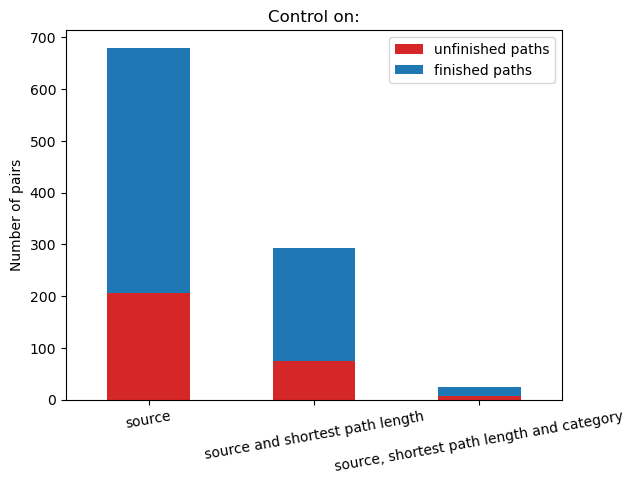

In [35]:
ax = combinations.plot.bar(rot=10, stacked = True, color = ['tab:red', 'tab:blue'], 
                           title = "Control on:",
                           ylabel = "Number of pairs", width = 0.5)

plt.show()